# Procesamiento data covid 19

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to create DataFrames
def create_df(path: str, name: str):
    return pd.read_csv(path + name, index_col=0)

In [3]:
path = '/work/covid-ec/data/raw/'

In [4]:
# Creating DataFrames
deaths_2021 = create_df(path, 'deaths_2021.csv')
deaths_2020 = create_df(path, 'deaths_2020.csv')
positives_2021 = create_df(path, 'positives_2021.csv')
positives_2020 = create_df(path, 'positives_2020.csv')
vaccines = create_df(path, 'vaccines.csv')

In [5]:
print(deaths_2020.sample(2))

      provincia  poblacion  total  acumuladas       lat        lng  created_at
8226  Pichincha    3228233     48       18504 -0.218611 -78.509722  08/12/2020
6501  Sucumbíos     230503      0         741  0.084722 -76.882778  27/09/2020


In [6]:
print(positives_2020.sample(2))

     provincia  poblacion  total  nuevas       lat        lng  created_at
3985   Bolívar     209933   1417      10 -1.605556 -79.003056  26/08/2020
1393   Bolívar     209933    167       4 -1.605556 -79.003056  10/05/2020


In [7]:
print(vaccines.sample(2))

          fecha  dosis_total  primera_dosis  segunda_dosis  refuerzo
75   08/06/2021      2788245        1877548         910697         0
185  18/10/2021     21475888       11401817       10072729      1342


Los DataFrames de 2021 tienen la misma estructura que los de 2020, así que se analizan los 3 de distinta estructura para realizar su limpieza.

## Tipos de datos correctos y no nulos

In [8]:
print(deaths_2020.info(), positives_2020.info(), vaccines.info(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   provincia   8784 non-null   object 
 1   poblacion   8784 non-null   int64  
 2   total       8784 non-null   int64  
 3   acumuladas  8784 non-null   int64  
 4   lat         8784 non-null   float64
 5   lng         8784 non-null   float64
 6   created_at  8784 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 549.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7056 entries, 0 to 7055
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   provincia   7056 non-null   object 
 1   poblacion   7056 non-null   int64  
 2   total       7056 non-null   int64  
 3   nuevas      7056 non-null   int64  
 4   lat         7056 non-null   float64
 5   lng         7056 non-null   float64
 6   created_at  7056 non-n

No hay datos nulos. Se debe cambiar el tipo `object` por `datetime`:

In [9]:
deaths_2021['created_at'] = pd.to_datetime(deaths_2021['created_at'], dayfirst=True)
deaths_2020['created_at'] = pd.to_datetime(deaths_2020['created_at'], dayfirst=True)
positives_2021['created_at'] = pd.to_datetime(positives_2021['created_at'], dayfirst=True)
positives_2020['created_at'] = pd.to_datetime(positives_2020['created_at'], dayfirst=True)
vaccines['fecha'] = pd.to_datetime(vaccines['fecha'], dayfirst=True)

## Concatenar datasets

Se concatena los datasets de deaths y positives (2020 y 2021) para facilitar el análisis.

In [10]:
deaths = pd.concat([deaths_2020, deaths_2021])
positives = pd.concat([positives_2020, positives_2021])

## Datos homogéneos

Se busca posibles errores (números fuera de lo común o negativos).

### Positives dataset

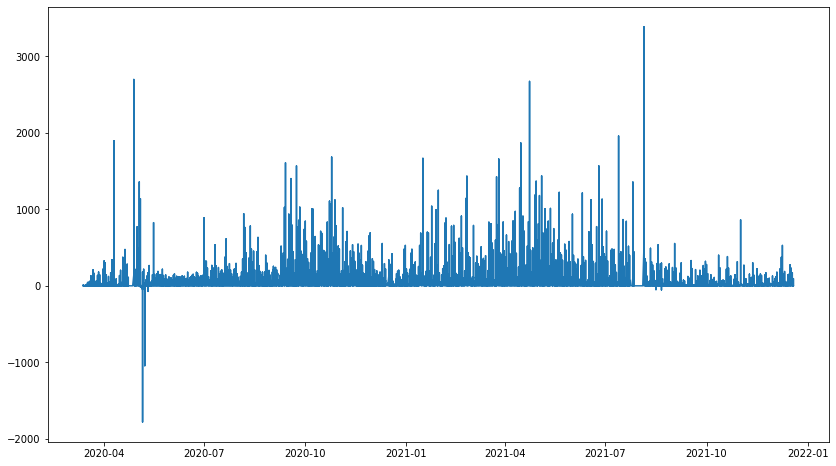

In [11]:
plt.figure(figsize=[14, 8])
plt.plot(positives.created_at, positives.nuevas)
plt.show()

Hay datos negativos de casos positivos, debe ser un error, así que se hace la transformación.

In [12]:
to_replace = positives.query('nuevas < 0')['nuevas'].values
replaced = to_replace * (-1)
positives['nuevas'].replace(to_replace, replaced, inplace=True)

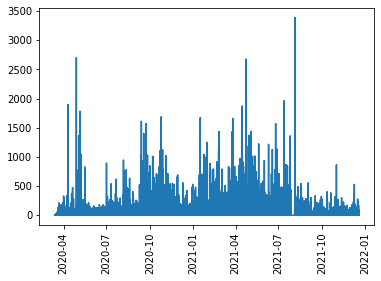

In [13]:
plt.plot(positives.created_at, positives.nuevas)
plt.xticks(rotation=90)
plt.show()

Se sigue con la revisión de los datasets para asegurarse de que no haya más anomalías.

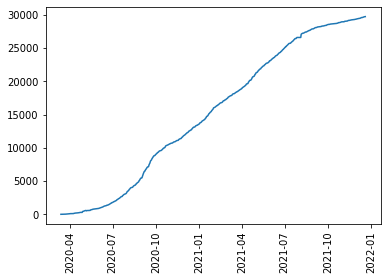

In [14]:
x=positives.query('provincia=="Azuay"')['created_at']
y=positives.query('provincia=="Azuay"')['total']
plt.plot(x, y)
plt.xticks(rotation=90)
plt.show()

La columna `total` muestra el acumulado por provincias, por lo que se la renombrará por `acumulados_provincia`.

In [15]:
positives.rename(columns={'total': 'acumulados_provincia'}, inplace=True)

Las columnas `lat` y `lng` no las ocuparé para el análisis, se las elimina.

In [16]:
positives.drop(['lat', 'lng'], axis='columns', inplace=True)

Se crea la nueva columna `acumulados` que llevará nuevos casos positivos acumulados por fechas.

In [17]:
positives['acumulados'] = positives['nuevas'].cumsum()

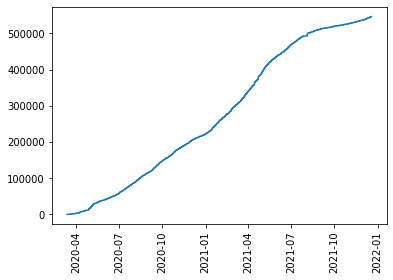

In [18]:
plt.plot(positives.created_at, positives.acumulados)
plt.xticks(rotation=90)
plt.show()

Mucho mejor. Ahora los siguientes 2 datasets:

### Deaths dataset

Comprobar que `poblacion` es el mismo valor (debería tener 24 valores únicos para las 24 provincias).

In [19]:
len(deaths['poblacion'].unique())

24

Se verifica la columna `acumuladas`.

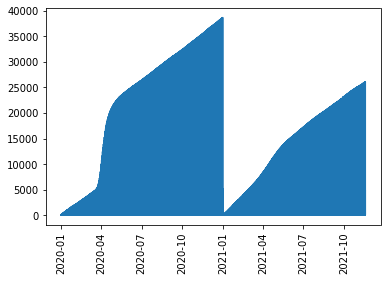

In [20]:
plt.plot(deaths.created_at, deaths.acumuladas)
plt.xticks(rotation=90)
plt.show()

El dataset se reinicia en el año 2021. Así que se reemplaza dicha columna por los valores correctos y también se crea las acumuladas por provincia. Además, se renombrará la columna `total` por `nuevas` para mantener homogeneidad con el dataset anterior.

In [21]:
deaths.rename(columns={'total': 'nuevas'}, inplace=True)

In [22]:
# Drop unnecessary columns
deaths.drop(['lat', 'lng'], axis='columns', inplace=True)

In [23]:
deaths['acumuladas'] = deaths['nuevas'].cumsum()
deaths['acumuladas_provincia'] = deaths.groupby('provincia')['nuevas'].cumsum()

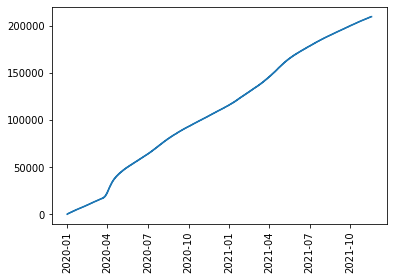

In [24]:
plt.plot(deaths.created_at, deaths.acumuladas)
plt.xticks(rotation=90)
plt.show()

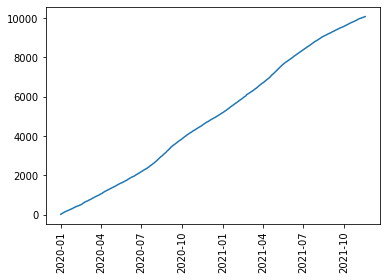

In [25]:
x=deaths.query('provincia=="Azuay"')['created_at']
y=deaths.query('provincia=="Azuay"')['acumuladas_provincia']
plt.plot(x, y)
plt.xticks(rotation=90)
plt.show()

### Vaccines dataset

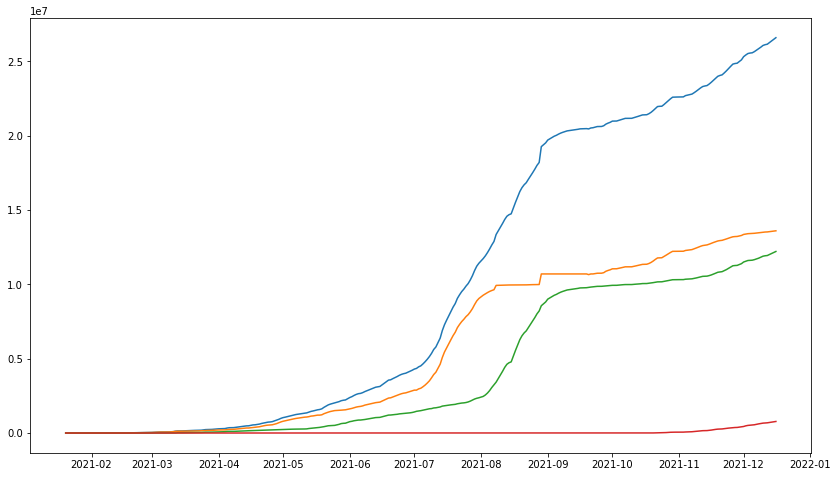

In [26]:
plt.figure(figsize=[14, 8])
plt.plot(vaccines.fecha, vaccines.dosis_total, label='total')
plt.plot(vaccines.fecha, vaccines.primera_dosis, label='primera')
plt.plot(vaccines.fecha, vaccines.segunda_dosis, label='segunda')
plt.plot(vaccines.fecha, vaccines.refuerzo, label='refuerzo')
plt.show()

### Exportar data procesada

Resumen de cómo quedaron los datasets para exportarlos y analizarlos:

In [27]:
positives.head()

,provincia,poblacion,acumulados_provincia,nuevas,created_at,acumulados
0,Azuay,881394,0,0,2020-03-13,0
1,Bolívar,209933,0,0,2020-03-13,0
2,Carchi,186869,0,0,2020-03-13,0
3,Cañar,281396,0,0,2020-03-13,0
4,Chimborazo,524004,0,0,2020-03-13,0


In [28]:
deaths.head()

,provincia,poblacion,nuevas,acumuladas,created_at,acumuladas_provincia
0,Azuay,881394,21,21,2020-01-01,21
1,Bolívar,209933,2,23,2020-01-01,2
2,Carchi,186869,1,24,2020-01-01,1
3,Cañar,281396,8,32,2020-01-01,8
4,Chimborazo,524004,7,39,2020-01-01,7


In [29]:
vaccines.head()

,fecha,dosis_total,primera_dosis,segunda_dosis,refuerzo
0,2021-01-20,0,0,0,0
1,2021-01-21,0,0,0,0
2,2021-01-22,108,108,0,0
3,2021-01-27,2982,2982,0,0
4,2021-02-04,6228,6228,0,0


In [30]:
# df_name.to_csv('/work/covid-ec/data/processed/name.csv', index=None)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7b048df-fc9b-4970-aa88-df153b270a6f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>